<a href="https://colab.research.google.com/github/FRashidy1403/Modified-U_Net/blob/main/Modified_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Libraries**

if each one is not installed please instal it as:

! pip install numpy

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

**Prepared Data**

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
print(info)   # for study the detail of dataset

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLab

**This function resize the image**

In [ ]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask

**this function augment the image**

In [ ]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

**this function normalize the image**

In [ ]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1

    return input_image, input_mask

**this function load image_train**

In [ ]:
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

**this function load image_train**

In [ ]:
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

**define two hypeparameters**

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [ ]:
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

display

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

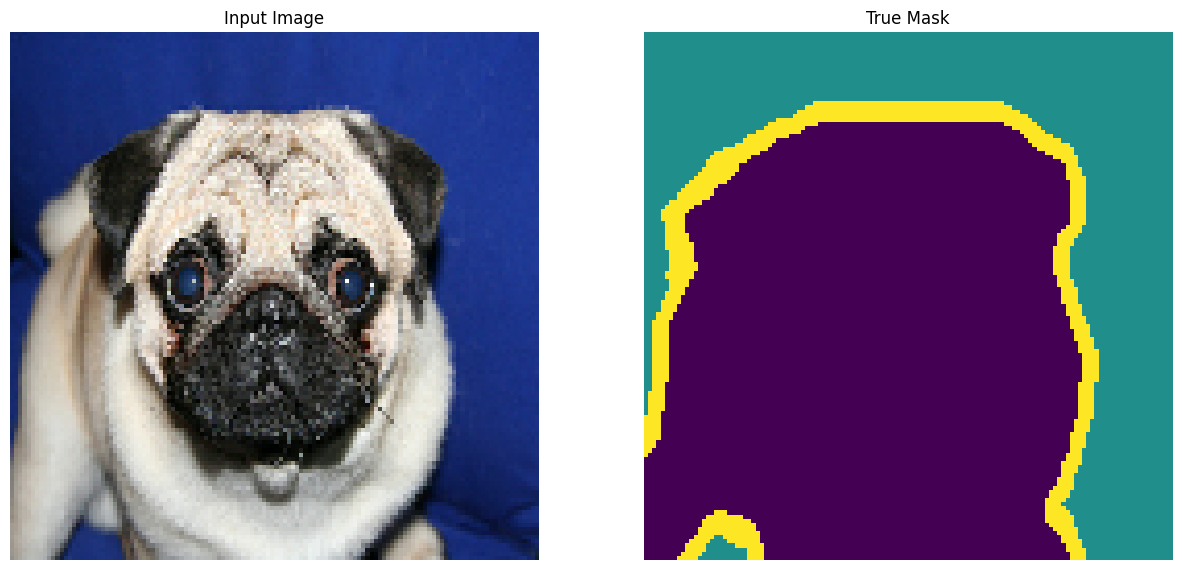

In [ ]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [ ]:
sample_image.shape

TensorShape([128, 128, 3])

In [ ]:
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [ ]:
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [ ]:
 def upsample_block(x, conv_features, n_filters):
    # upsample
    x1 = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)

     # concatenate
    x = layers.concatenate([x1, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)

    return x, x1

# u Net

In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6, x1 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7, x1 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8, x1 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9, x1 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [ ]:
NUM_EPOCHS = 50
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.5427 - loss: 1.0056 - val_accuracy: 0.5733 - val_loss: 0.8671
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 99s 883ms/step - accuracy: 0.6504 - loss: 0.7925 - val_accuracy: 0.7131 - val_loss: 0.6915
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7330 - loss: 0.6633 - val_accuracy: 0.7642 - val_loss: 0.5944
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 871ms/step - accuracy: 0.7625 - loss: 0.5969 - val_accuracy: 0.7626 - val_loss: 0.6155
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 884ms/step - accuracy: 0.7825 - loss: 0.5508 - val_accuracy: 0.7657 - val_loss: 0.5786
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7891 - loss: 0.5338 - val_accuracy: 0.8167 - val_loss: 0.4783
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 50s 875ms/step - accuracy: 0.8121 - loss: 0.4790 - val_accuracy: 0.8235 - val_loss: 0.4486
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8211 - loss: 0.4599 - val_accuracy: 0.831

In [ ]:
def display_learning_curves(history):
    acc0 = history.history["accuracy"]
    val_acc0 = history.history["val_accuracy"]

    loss0 = history.history["loss"]
    val_loss0 = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))
    fig.suptitle('U_Net', fontsize=18, color='b',y=0.95)
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc0, label="train accuracy")
    plt.plot(epochs_range, val_acc0, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss0, label="train loss")
    plt.plot(epochs_range, val_loss0, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()
    return acc0, val_acc0, loss0, val_loss0

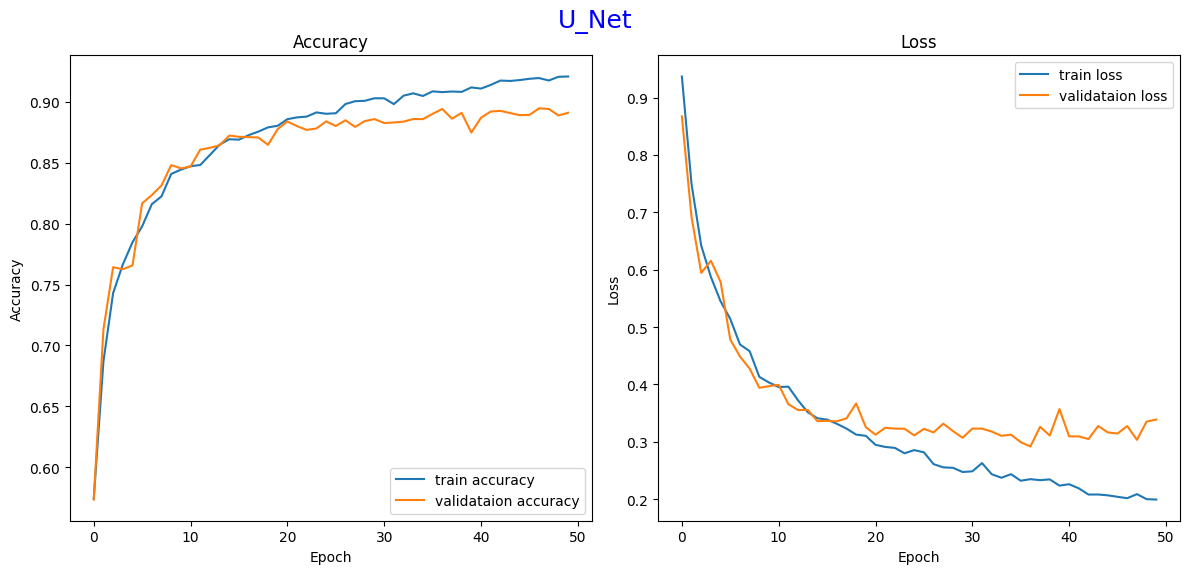

In [ ]:
# Display learning curves
acc0, val_acc0, loss0, val_loss0 = display_learning_curves(unet_model.history)

In [ ]:
acc0 = pd.DataFrame(acc0)
val_acc0 = pd.DataFrame(val_acc0)
loss0 = pd.DataFrame(loss0)
val_loss0 = pd.DataFrame(val_loss0)

In [ ]:
acc0.to_excel('Acc0.xlsx')
val_acc0.to_excel('Val_Acc0.xlsx')
loss0.to_excel('Loss0.xlsx')
val_loss0.to_excel('Val_Loss0.xlsx')

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step


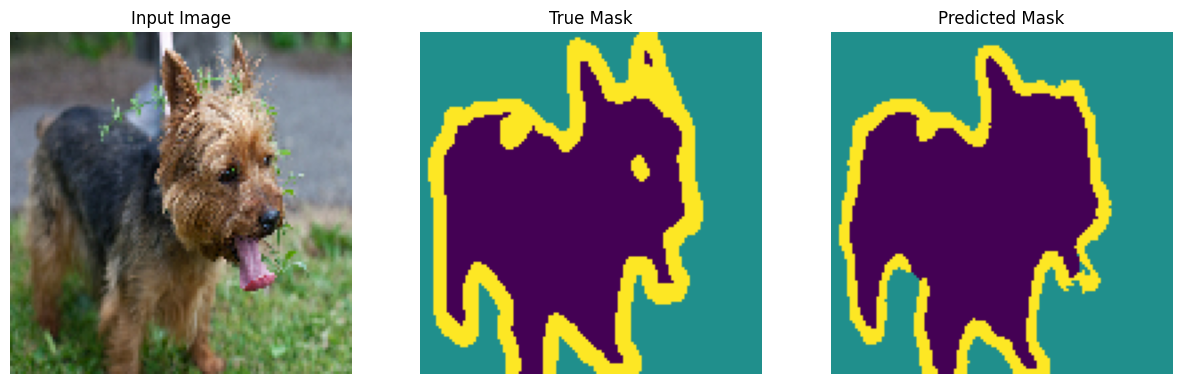

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


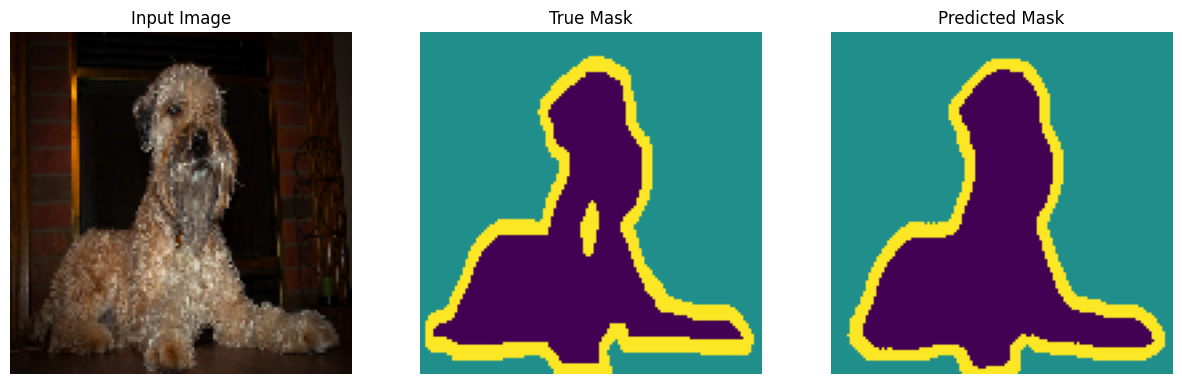

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


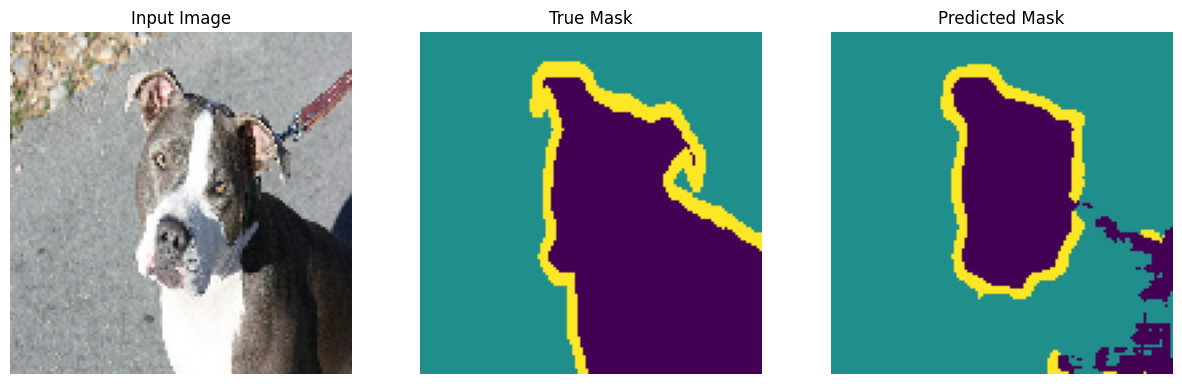

In [ ]:
show_predictions(test_batches.skip(5), 3)

# **w** ***net1*** with 2 step(up & down):


In [ ]:
def simple_unet_model_1():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck1 = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6, x1 = upsample_block(bottleneck1, f4, 512)
    # 7 - upsample
    u7,x2 = upsample_block(u6, f3, 256)

    bottleneck2 = double_conv_block(x2, 128)

    # 1 - downsample
    f5, p5 = downsample_block(bottleneck2, 256)
    # 2 - downsample
    f6, p6 = downsample_block(p5, 512)

    bottleneck3 = double_conv_block(p6, 1024)

    # 1 - upsample
    u8, x3 = upsample_block(bottleneck3, f6, 512)
    # 2 - upsample
    u9, x4 = upsample_block(u8, f5, 256)

    # 8 - upsample
    u10, x5 = upsample_block(u9, f2, 128)
    # 9 - upsample
    u11, x6 = upsample_block(u10, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u11)

    # unet model with Keras Functional API
    wnet1_model = tf.keras.Model(inputs, outputs, name="W-Net")

    return wnet1_model

In [ ]:
wnet1_model = simple_unet_model_1()

In [ ]:
wnet1_model.summary()

Model: "W-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 66,517,059 (253.74 MB)

 Trainable params: 66,517,059 (253.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
wnet1_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [ ]:
NUM_EPOCHS = 50
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = wnet1_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.5566 - loss: 1.0363 - val_accuracy: 0.5821 - val_loss: 0.8503
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.6670 - loss: 0.7758 - val_accuracy: 0.7199 - val_loss: 0.6866
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7333 - loss: 0.6590 - val_accuracy: 0.7503 - val_loss: 0.6247
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7558 - loss: 0.6091 - val_accuracy: 0.7804 - val_loss: 0.5575
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7803 - loss: 0.5558 - val_accuracy: 0.8015 - val_loss: 0.5100
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.7935 - loss: 0.5248 - val_accuracy: 0.7904 - val_loss: 0.5239
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8075 - loss: 0.4921 - val_accuracy: 0.8304 - val_loss: 0.4443
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8266 - loss: 0.4499 - val_accuracy: 0.8364 - val_los

In [ ]:
def display_learning_curves(history):
    acc1 = history.history["accuracy"]
    val_acc1 = history.history["val_accuracy"]

    loss1 = history.history["loss"]
    val_loss1 = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))
    fig.suptitle('Warm_Net with two steps', fontsize=18, color='b',y=0.95)
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc1, label="train accuracy")
    plt.plot(epochs_range, val_acc1, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss1, label="train loss")
    plt.plot(epochs_range, val_loss1, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()
    return acc1, val_acc1, loss1, val_loss1

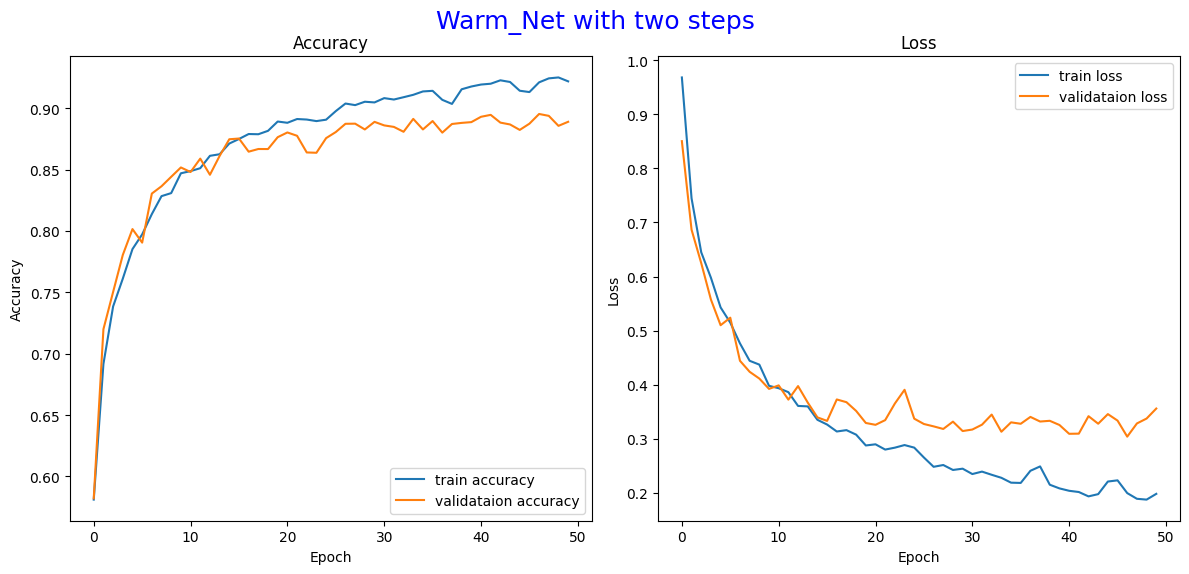

In [ ]:
# Display learning curves
acc1, val_acc1, loss1, val_loss1 = display_learning_curves(wnet1_model.history)

In [ ]:
acc1 = pd.DataFrame(acc1)
val_acc1 = pd.DataFrame(val_acc1)
loss1 = pd.DataFrame(loss1)
val_loss1 = pd.DataFrame(val_loss1)

In [ ]:
acc1.to_excel('Acc1.xlsx')
val_acc1.to_excel('Val_Acc1.xlsx')
loss1.to_excel('Loss1.xlsx')
val_loss1.to_excel('Val_Loss1.xlsx')

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = wnet1_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(wnet1_model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step


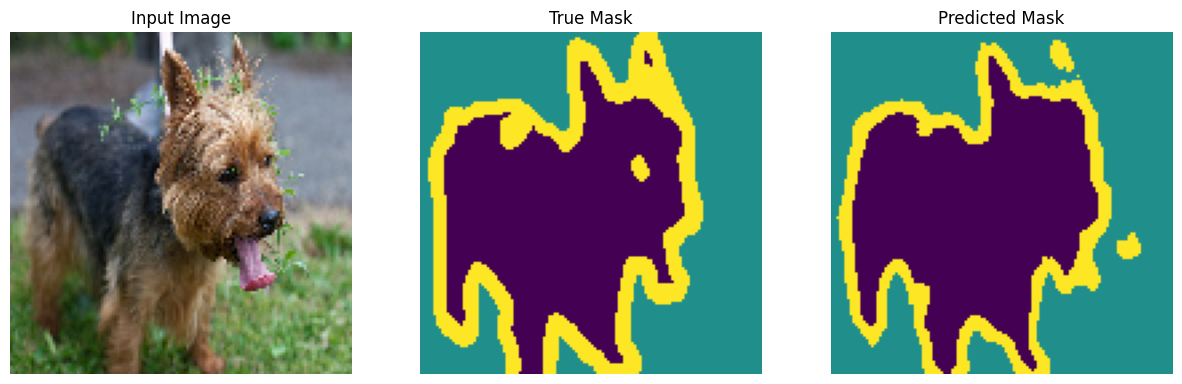

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


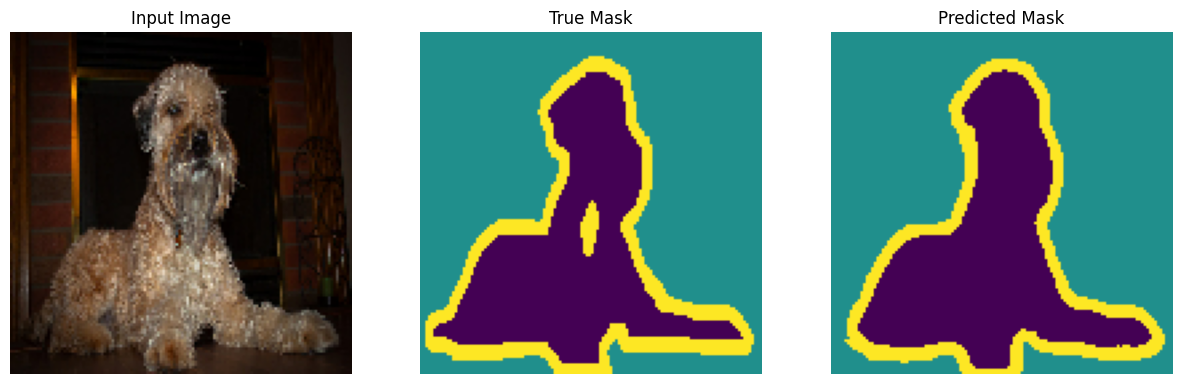

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


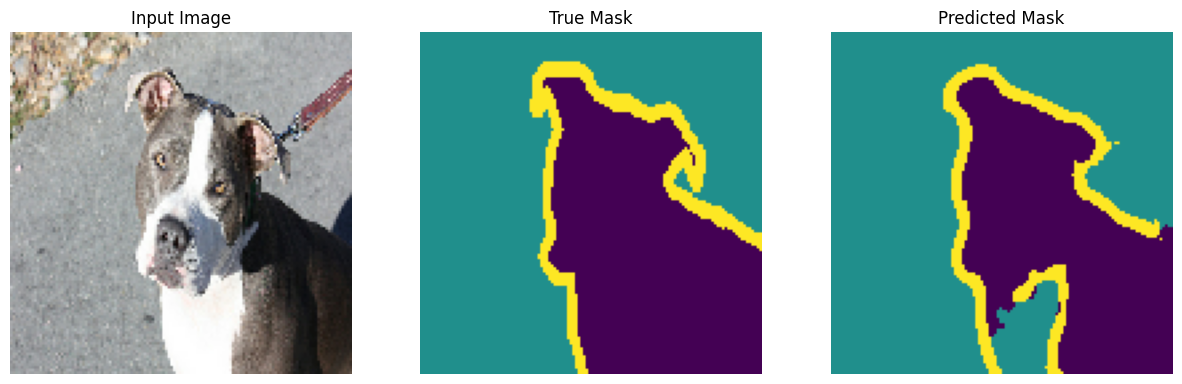

In [ ]:
show_predictions(test_batches.skip(5), 3)

# W Net 2  whit x ---->f

In [ ]:
def simple_unet_model_2():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck1 = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6, x1 = upsample_block(bottleneck1, f4, 512)
    # 7 - upsample
    u7,x2 = upsample_block(u6, f3, 256)

    bottleneck2 = double_conv_block(x2, 128)

    # 1 - downsample
    f5, p5 = downsample_block(bottleneck2, 256)
    # 2 - downsample
    f6, p6 = downsample_block(p5, 512)

    bottleneck3 = double_conv_block(p6, 1024)

    # 1 - upsample
    u8, x3 = upsample_block(bottleneck3, f4, 512)
    # 2 - upsample
    u9, x4 = upsample_block(u8, f3, 256)

    # 8 - upsample
    u10, x5 = upsample_block(u9, f2, 128)
    # 9 - upsample
    u11, x6 = upsample_block(u10, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u11)

    # unet model with Keras Functional API
    wnet_model = tf.keras.Model(inputs, outputs, name="W-Net")

    return wnet_model

In [ ]:
wnet2_model = simple_unet_model_2()

In [ ]:
wnet2_model.summary()

Model: "W-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_31[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_32[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 64, 64,    │          0 │ max_pooling2d_6[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_33[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_34[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 32, 32,    │          0 │ max_pooling2d_7[… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │    295,168 │ dropout_13[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_35[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ conv2d_36[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 16, 16,    │          0 │ max_pooling2d_8[… │
│ (Dropout)           │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ dropout_14[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_37[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 8, 8, 512) │          0 │ conv2d_38[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 8, 8, 512) │          0 │ max_pooling2d_9[

 Total params: 66,517,059 (253.74 MB)

 Trainable params: 66,517,059 (253.74 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
wnet2_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics=["accuracy"])

In [ ]:
NUM_EPOCHS = 50
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = wnet2_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.5345 - loss: 1.0802 - val_accuracy: 0.5733 - val_loss: 0.9596
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.5859 - loss: 0.8691 - val_accuracy: 0.5742 - val_loss: 0.8680
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6100 - loss: 0.8090 - val_accuracy: 0.6989 - val_loss: 0.7227
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7072 - loss: 0.6972 - val_accuracy: 0.7468 - val_loss: 0.6325
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7465 - loss: 0.6279 - val_accuracy: 0.7677 - val_loss: 0.5834
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.7725 - loss: 0.5739 - val_accuracy: 0.7508 - val_loss: 0.5935
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7784 - loss: 0.5542 - val_accuracy: 0.7969 - val_loss: 0.5289
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.7989 - loss: 0.5180 - val_accuracy: 0.8045 - val_loss:

In [ ]:
def display_learning_curves(history):
    acc2 = history.history["accuracy"]
    val_acc2 = history.history["val_accuracy"]

    loss2 = history.history["loss"]
    val_loss2 = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))
    fig.suptitle('Warm_Net with jump f', fontsize=18, color='b',y=0.95)
    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc2, label="train accuracy")
    plt.plot(epochs_range, val_acc2, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss2, label="train loss")
    plt.plot(epochs_range, val_loss2, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()
    return acc2, val_acc2, loss2, val_loss2

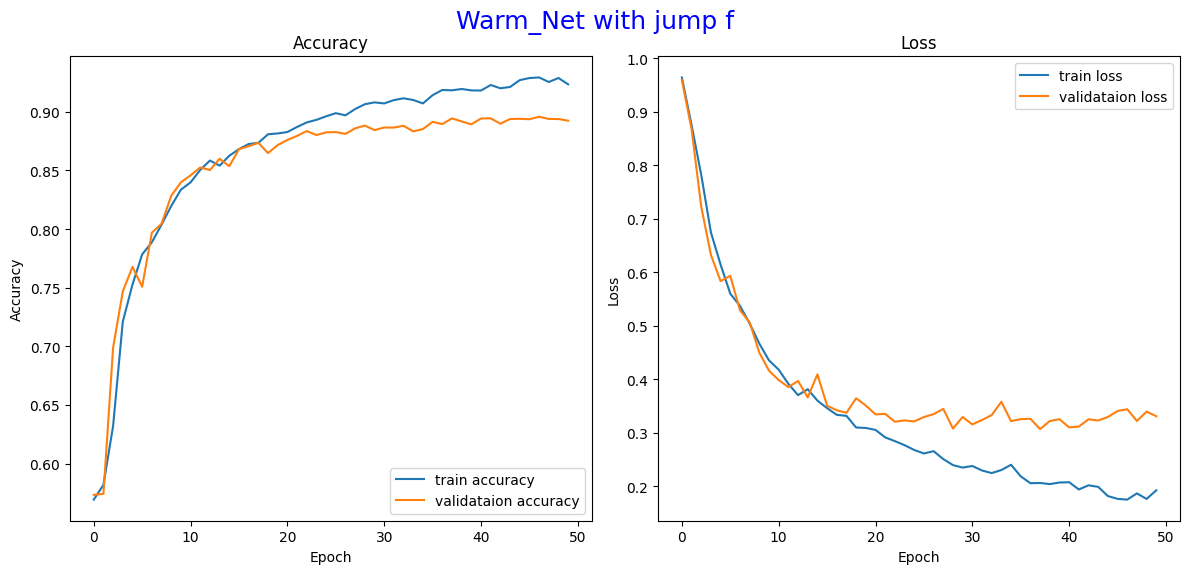

In [ ]:
# Display learning curves
acc2, val_acc2, loss2, val_loss2 = display_learning_curves(wnet2_model.history)

In [ ]:
acc2 = pd.DataFrame(acc2)
val_acc2 = pd.DataFrame(val_acc2)
loss2 = pd.DataFrame(loss2)
val_loss2 = pd.DataFrame(val_loss2)

In [ ]:
acc2.to_excel('Acc2.xlsx')
val_acc2.to_excel('Val_Acc2.xlsx')
loss2.to_excel('Loss2.xlsx')
val_loss2.to_excel('Val_Loss2.xlsx')

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = wnet2_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(wnet2_model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step


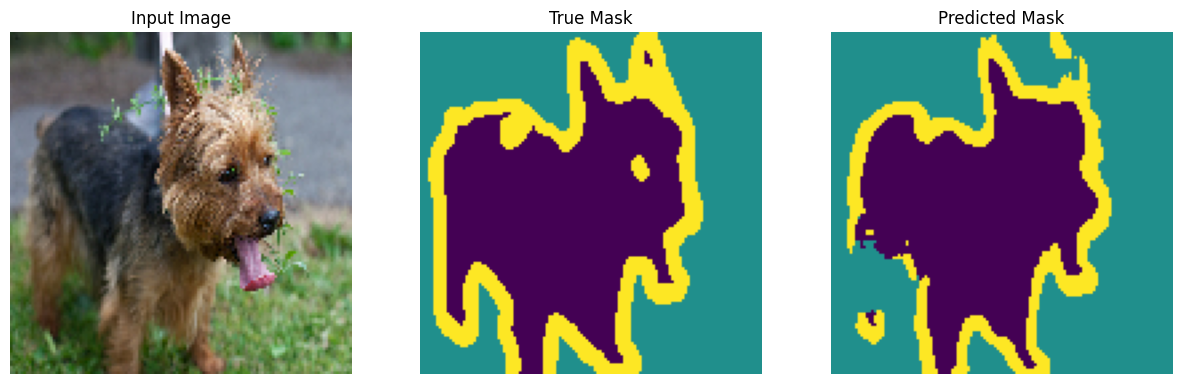

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step


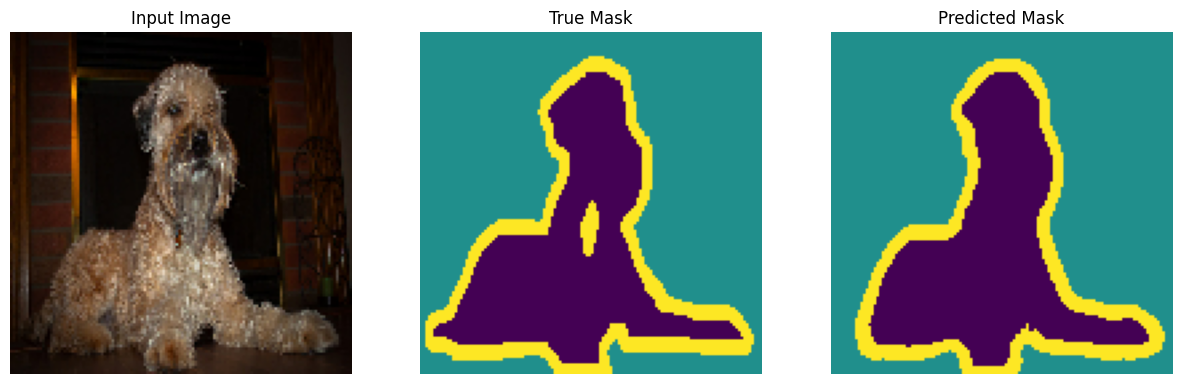

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step


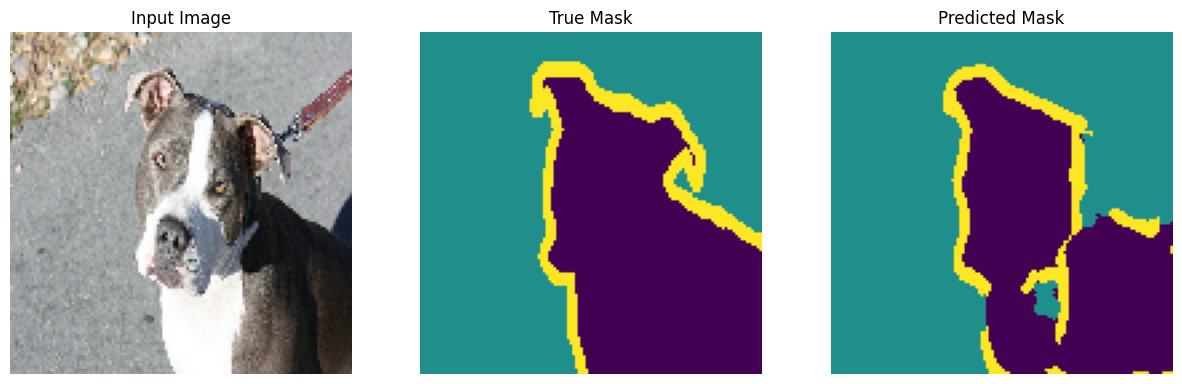

In [ ]:
show_predictions(test_batches.skip(5), 3)